<a href="https://colab.research.google.com/github/AndreTeixeir/hackathon-one-sentiment-api/blob/main/Hackathon_One_Nb1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='orange'> **SentimentAPI — Análise de Sentimentos de Avaliações**

- <font color='red'> **Notebook 1**

## Projeto desenvolvido no Hackathon X

**Objetivo:**  
Construir um modelo de Machine Learning capaz de classificar o sentimento
(positivo / negativo / neutro) de avaliações textuais, integrável a uma API.

**Equipe de Data Science:**  
- Brena Stephany  
- Eyka
- Leticia

**Modelo:** TF-IDF + Logistic Regression  

# <font color='blue'>**Importação de Bibliotecas**

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

!pip install nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report)

import joblib

# <font color='blue'>**Extração dos Dados**

In [122]:
url = "https://raw.githubusercontent.com/AndreTeixeir/hackathon-one-sentiment-api/refs/heads/main/datascience/hopi_hari%20(1).csv"
df = pd.read_csv(url, sep=';')
df.head()


,comentario,nota,data
0,Filas de mais de 3 horas nos brinquedos.Filas ...,1.0,mar de 2023
1,"Parque lotado, fila da Montezum demorou mais d...",3.0,mar de 2023
2,"Muito ruim, caiu na qualidade. Muito demorado....",1.0,mar de 2023
3,"O parque atende a diversas faixa etária, fomos...",4.0,fev de 2023
4,DecadenteSó vá ao parque se:a) Você poder perd...,2.0,fev de 2023


# <font color='blue'>**Preparação dos Dados (Data Cleaning)**

### <font color='whitblue'> **Analisando o DataSet**

In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4044 entries, 0 to 4043
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   comentario  4044 non-null   object 
 1   nota        4044 non-null   float64
 2   data        4044 non-null   object 
dtypes: float64(1), object(2)
memory usage: 94.9+ KB


In [124]:
df.isnull().sum()

,0
comentario,0
nota,0
data,0


In [125]:
df.shape

(4044, 3)

In [126]:
print(df['comentario'][0])

Filas de mais de 3 horas nos brinquedos.Filas de mais de 1 hora para comprar água.Sem estrutura.Chegamos na abertura do parque conseguimos ir em 2 brinquedos.Sem organização nas filas.Sem funcionários preparadosBrinquedos ok, mas nada demais.


O dataset apresenta 3 colunas, 4044 linhas e nenhum valor nulo.


### <font color='whitblue'> **Tamanho dos comentários (número de caracteres)**

In [127]:
df['tamanho_texto'] = df['comentario'].apply(len)

df['tamanho_texto'].describe()


,tamanho_texto
count,4044.000000
mean,431.837290
std,462.287227
min,61.000000
25%,181.000000
50%,293.000000
75%,513.000000
max,8708.000000


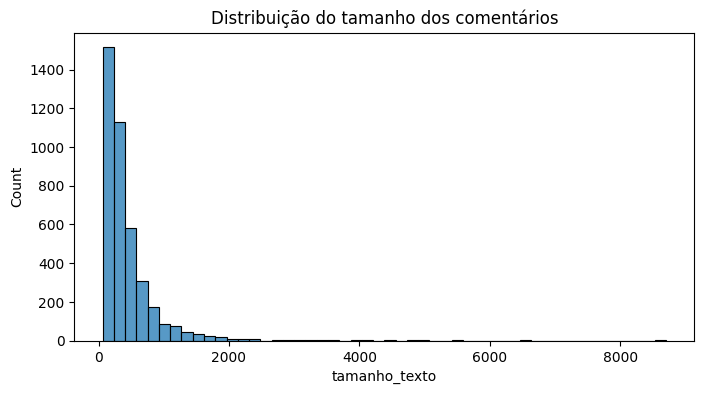

In [128]:
plt.figure(figsize=(8,4))
sns.histplot(df['tamanho_texto'], bins=50)
plt.title("Distribuição do tamanho dos comentários")
plt.show()

### <font color='whitblue'> **Palavras mais frequentes**

In [129]:
from collections import Counter
import re

texto_unido = " ".join(df['comentario'].str.lower())
palavras = re.findall(r'\b\w+\b', texto_unido)

contagem = Counter(palavras)
contagem.most_common(20)


[('e', 9813),
 ('de', 9245),
 ('o', 8839),
 ('a', 7402),
 ('que', 7355),
 ('parque', 5899),
 ('para', 4537),
 ('não', 4471),
 ('é', 3926),
 ('com', 3879),
 ('um', 3738),
 ('em', 3726),
 ('brinquedos', 3570),
 ('do', 3283),
 ('no', 3066),
 ('muito', 3051),
 ('os', 2640),
 ('as', 2465),
 ('mais', 2403),
 ('uma', 2330)]

In [130]:
def limpar_texto(texto):
    """
    Função para limpar e normalizar o texto
    """
    texto = texto.lower()
    texto = re.sub(r'[^a-záàâãéèêíïóôõöúçñ\s]', '', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

In [131]:
  df['comentario'] = df['comentario'].apply(limpar_texto)

# <font color='blue'>**Criação da Variável Alvo (Label)**

Pre-Processamento

### <font color='whitblue'> **Classificação de Sentimentos**

<font color='red'> **Regra de rotulagem** (decisão da equipe de DS do projeto)

✔️ Para regressão logística binária

Regra escolhida:

* Positivo (1) → nota ≥ 4

* Negativo (0) → nota ≤ 3

In [132]:
def classificar_sentimento(score):
    if score <= 3:
        return '0'
    else:
        return '1'

In [133]:
df['sentimento'] = df['nota'].apply(classificar_sentimento)

In [134]:
#Remoção de registros sem classe definida

df = df.dropna(subset=['sentimento'])

In [135]:
df[["comentario", "nota", "sentimento"]].head()

,comentario,nota,sentimento
0,filas de mais de horas nos brinquedosfilas de ...,1.0,0
1,parque lotado fila da montezum demorou mais de...,3.0,0
2,muito ruim caiu na qualidade muito demorado um...,1.0,0
3,o parque atende a diversas faixa etária fomos ...,4.0,1
4,decadentesó vá ao parque sea você poder perder...,2.0,0


In [136]:
df['sentimento'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 4044 entries, 0 to 4043
Series name: sentimento
Non-Null Count  Dtype 
--------------  ----- 
4044 non-null   object
dtypes: object(1)
memory usage: 31.7+ KB


In [137]:
df['sentimento'] = df['sentimento'].astype(int)

In [138]:
#Classificação Ternária
"""
def map_sentiment_ternario(nota):
    if nota >= 4:
        return 2  # Positivo
    elif nota == 3:
        return 1  # Neutro
    elif nota <= 2:
        return 0  # Negativo
    else:
        return None


df['sentimento'] = df['nota'].apply(map_sentiment_ternario)
df = df.dropna(subset=['sentimento'])

"""

"\ndef map_sentiment_ternario(nota):\n    if nota >= 4:\n        return 2  # Positivo\n    elif nota == 3:\n        return 1  # Neutro\n    elif nota <= 2:\n        return 0  # Negativo\n    else:\n        return None\n\n\ndf['sentimento'] = df['nota'].apply(map_sentiment_ternario)\ndf = df.dropna(subset=['sentimento'])\n\n"

### <font color='whitblue'>**Análise da Distribuição das Classes**

Conferir balanceamento da classe

In [139]:
'''df["sentimento"].value_counts()'''

df["sentimento"].value_counts(normalize=True) * 100

,proportion
sentimento,
0,53.338279
1,46.661721


### <font color='red'>**Critério de Definição da Variável Alvo**

* A variável alvo do modelo foi construída a partir da nota de avaliação atribuída pelos usuários.

* As avaliações foram classificadas da seguinte forma:

     * Positivas: notas maiores ou iguais a 4.

     * Negativas: notas menores ou iguais a 2.

     * As avaliações com nota igual a 3 foram consideradas neutras.

* As observações neutras foram removidas do conjunto de dados, com o objetivo de:

     * Reduzir ambiguidades no processo de aprendizado.

     * Garantir maior clareza na distinção entre classes.

     * Melhorar o desempenho do modelo de aprendizado supervisionado binário.

# <font color='blue'>**Salvando o DataFrame Limpo**

In [157]:
# Selecionando apenas as colunas necessárias
df_final = df[['comentario', 'sentimento']]

df_final.to_csv('dataset_sentimento_limpo.csv', index=False, encoding='utf-8')

print("Dataset limpo salvo com sucesso!")

Dataset limpo salvo com sucesso!


# <font color='blue'>**Separação entre Treino e Teste**

In [140]:
X = df['comentario']
y = df['sentimento']

In [141]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y )

# <font color='blue'>**Vetorização de Texto (TF-IDF)**

Transformação dos Textos com TF-IDF

In [142]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [143]:
stopwords_pt = stopwords.words('portuguese')

In [144]:
tfidf = TfidfVectorizer(
    max_features=1000,
    min_df=2,
    max_df=0.95,
    ngram_range=(1, 2),
    stop_words=stopwords_pt
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [145]:
X_train_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 90381 stored elements and shape (3235, 1000)>

In [146]:
tfidf.get_feature_names_out()[:20]

array(['abandonado', 'abandono', 'abertas', 'aberto', 'abertos',
       'abertura', 'abre', 'abrir', 'abriu', 'absurdamente', 'absurdo',
       'absurdos', 'abusivo', 'abusivos', 'acaba', 'acabou', 'acesso',
       'achei', 'acho', 'acidente'], dtype=object)

# <font color='blue'>**Treinamento do Modelo**

Treinamento do Modelo de Regressão Logística

In [147]:
#Criação do modelo
model = LogisticRegression(
    max_iter=1000,
    solver='lbfgs')

In [148]:
#Treinamento do modelo
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [149]:
#Previsões no conjunto de teste
y_pred = model.predict(X_test_tfidf)
y_proba = model.predict_proba(X_test_tfidf)

# <font color='blue'>**Avaliação do Modelo**

Fazer predição e aplicar métricas de validação

In [153]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Acurácia: 0.8504
Precisão: 0.8497
Recall: 0.8249
F1-score: 0.8371


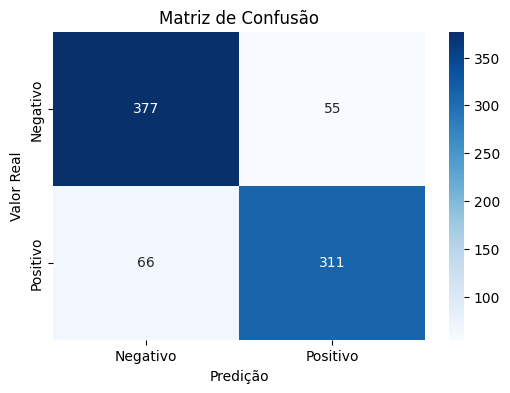

In [155]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Negativo', 'Positivo'],
    yticklabels=['Negativo', 'Positivo']
)

plt.xlabel('Predição')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão')
plt.show()

In [156]:
print(classification_report(
    y_test,
    y_pred,
    target_names=['Negativo', 'Positivo']
))

              precision    recall  f1-score   support

    Negativo       0.85      0.87      0.86       432
    Positivo       0.85      0.82      0.84       377

    accuracy                           0.85       809
   macro avg       0.85      0.85      0.85       809
weighted avg       0.85      0.85      0.85       809



## <font color='red'>**Interpretação dos Resultados das Métricas de Avaliação do Modelo**

O modelo de Regressão Logística apresentou um desempenho consistente e equilibrado na tarefa de classificação de sentimentos, conforme indicado pelas métricas de avaliação obtidas.

**Desempenho Geral**

* Acurácia (85,04%): o modelo acertou aproximadamente 85% das previsões no conjunto de teste, indicando uma boa capacidade de generalização.

* F1-score (83,71%): o valor elevado do F1-score demonstra um equilíbrio satisfatório entre precisão e recall, sendo especialmente relevante em cenários onde erros de classificação possuem custos distintos.

**Análise das Métricas por Classe**

* Classe Negativa:

   * Precisão: 85%

   * Recall: 87%

   * F1-score: 86%

  >O modelo apresenta excelente capacidade de identificar corretamente avaliações negativas, com baixo índice de falsos negativos.

* Classe Positiva:

   * Precisão: 85%

   * Recall: 82%

   * F1-score: 84%

  > Observa-se um leve decréscimo no recall, indicando que parte das avaliações positivas foi classificada incorretamente como negativa.

**Balanceamento do Modelo**

* As médias macro e ponderada apresentam valores semelhantes (≈85%), o que indica:

    * Ausência de viés significativo em favor de uma classe específica.

    * Desempenho equilibrado, mesmo com uma leve diferença no número de exemplos entre classes.

**Interpretação dos Resultados**

* O modelo demonstra maior sensibilidade para a classe Negativa, o que pode ser considerado positivo em contextos de análise de sentimento voltados para:

   * Monitoramento de insatisfação de clientes.

   * Identificação precoce de problemas em produtos ou serviços.

* O desempenho geral sugere que a combinação de TF-IDF com Regressão Logística é adequada para a tarefa proposta, mesmo utilizando um modelo linear e relativamente simples.

**Conclusão**

Os resultados indicam que o modelo é robusto, interpretável e eficiente para a classificação binária de sentimentos em avaliações de usuários. Ele pode ser utilizado como uma solução viável para aplicações reais, como apoio à tomada de decisão em marketing, análise de reputação de produtos e monitoramento da experiência do cliente.

# <font color='blue'>**Serialização do Modelo**

Salvando o Modelo Treinado (Essencial para integração com o Back-End.)

In [151]:
"""
joblib.dump(model, "sentiment_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

"""

'\njoblib.dump(model, "sentiment_model.pkl")\njoblib.dump(tfidf, "tfidf_vectorizer.pkl")\n\n'

# <font color='blue'>**Teste Manual de Predição**

Testar manualmente Modelo de Classifição treinado.